In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from pandas.plotting import register_matplotlib_converters
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
import datetime as dt
import scipy as sp
import os

In [2]:
os.getcwd()

'C:\\Users\\6nico\\Documents\\Académico\\Talento Tech\\Tecnico\\TalentoTech-AVD\\Proyecto'

Los datos se encuentran [aqui](https://www.kaggle.com/datasets/ruslanzalevskikh/oil-well). Hacen referencia a distintas mediciones de un mismo pozo petrolero en Rusia. El pozo fue perforado en 2013 y cuenta con una profundidad de 2400 metros.

Estas son las variables y hacen referencia a lo siguiente:
1. **OilVol**: $\text{m}^3 / \text{día}$ el vólumen de petróleo producido
2. **VolLiq**: $\text{m}^3 / \text{día}$ la cantidad total de líquido (mezcla de petróleo, gas y agua) que el pozo produce diariamente en metros cúbicos.
3. **GasVol**: $\text{m}^3 / \text{día}$ la cantidad de gas producido por el pozo por día en metros cúbicos.
4. **WaterVol**: $\text{m}^3 / \text{día}$ Cantidad de agua extraída.
5. **WaterCut**: % El porcentaje de agua presente en el líquido extraído del pozo; es la proporción de agua en  cantidad total del líquido producido.
6. **WorkTime** Número de horas de operación al día.
7. **DnmcLvl**: $\text{m}$ es la altura a la que se encuentra el fluido dentro del pozo mientras la bomba está en funcionamiento y el pozo está produciendo.
8. **Pressure**: $\text{atm}$ es la presión del reservorio medida en atmósferas, la presión disminuye a medida que el pozo es explotado.

Máximo 20% en watercut

# Limpieza de datos

In [3]:
datos = pd.read_excel("Oil well.xlsx" )

In [4]:
datos.head()

Oil well operation parameters (2013 - 2021 y). Well № 807  \
0                                                NaN          
1                                               Date          
2                                2013-01-01 00:00:00          
3                                2013-01-02 00:00:00          
4                                2013-01-03 00:00:00          

              Unnamed: 1                 Unnamed: 2             Unnamed: 3  \
0                    NaN                        NaN                    NaN   
1  \nOil volume (m3/day)  Volume of liquid (m3/day)  \nGas volume (m3/day)   
2                     49                         70                  13055   
3                     49                         70                  13055   
4                     49                         70                  13055   

              Unnamed: 4      Unnamed: 5       Unnamed: 6  \
0                    NaN             NaN              NaN   
1  Water volume (m3/day)  Water cut (%)   \nWorking hours   
2                     21              29               24   
3                     21              29               24   
4                     21              29               24   

            Unnamed: 7                  Unnamed: 8  
0                  NaN                         NaN  
1  \nDynamic level (m)  \nReservoir pressure (atm)  
2                 1819                         214  
3                 1836                         214  
4                 1788                         214

In [5]:
datos.columns=['Fecha','OilVol','VolLiq','GasVol','WaterVol','WaterCut','WorkHours','DnmcLvl','Pressure']

In [6]:
datos.drop([0,1],inplace=True)

In [7]:
# Convierte la columna Fecha a tipo datetime
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
 
# Establece el índice del d.f. con la columna 'Date'
datos.index = datos['Fecha']
datos2 = datos.copy()

# Elimina la calumna Date del d.f.
datos.drop('Fecha',inplace=True, axis=1); datos

# Convertir todas las columnas de tipo object a numéricas
datos[datos.select_dtypes(include=['object']).columns] = datos.select_dtypes(include=['object']).apply(pd.to_numeric, errors='coerce')


In [8]:
datos.describe()

OilVol       VolLiq        GasVol     WaterVol     WaterCut  \
count  2939.000000  2939.000000   2939.000000  2939.000000  2939.000000   
mean     17.624362    59.464103   4730.146308    41.828853    70.694794   
std       9.689026    18.634101   2598.888524    13.056625     9.534203   
min       0.000000    12.000000      4.000000     9.000000    29.000000   
25%      11.000000    50.000000   3041.500000    33.000000    69.000000   
50%      15.000000    58.000000   3909.000000    43.000000    73.000000   
75%      22.000000    74.000000   5843.500000    50.000000    76.000000   
max      49.000000   113.000000  13113.000000    99.000000   100.000000   

         WorkHours      DnmcLvl     Pressure  
count  2939.000000  2939.000000  2939.000000  
mean     22.344675  1930.383464   157.019054  
std       3.039553   114.543752    32.917150  
min       7.000000  1529.000000   100.000000  
25%      22.000000  1855.000000   129.000000  
50%      24.000000  1890.000000   157.000000  
75%      24.000000  2008.000000   185.500000  
max      24.000000  2137.000000   214.000000

Dado a que los datos corresponden a las mediciones diarias en cada una de las 8 variables en **UN MISMO POZO**, no es posible ajustar un modelo lineal mixto generalizado pues hay que tener al menos dos individuos o clusters. Por lo tanto debemos ajustar un modelo de series de tiempo a cada variable y caracterizar la estructura de correlación para realizar la predicción a 1 o 2 años.

In [9]:
datos.head()

OilVol  VolLiq  GasVol  WaterVol  WaterCut  WorkHours  DnmcLvl  \
Fecha                                                                        
2013-01-01      49      70   13055        21        29         24     1819   
2013-01-02      49      70   13055        21        29         24     1836   
2013-01-03      49      70   13055        21        29         24     1788   
2013-01-04      49      70   13055        21        29         24     1789   
2013-01-05      44      70   11768        26        36         24     1825   

            Pressure  
Fecha                 
2013-01-01       214  
2013-01-02       214  
2013-01-03       214  
2013-01-04       214  
2013-01-05       214

In [10]:
print(datos.index)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12',
               '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16',
               '2021-01-17', '2021-01-18'],
              dtype='datetime64[ns]', name='Fecha', length=2939, freq=None)


In [11]:
datos.index.isna().sum()

0

El índice de fechas no tiene datos faltantes **NaT**, sin embargo hay saltos entre las fechas y se evidencia en la siguiente celda.

In [12]:
# Calcular las diferencias entre fechas consecutivas en el índice
saltos = datos.index.to_series().diff()

# Mostrar los saltos diferentes a 1 día
saltos_irregulares = saltos[saltos != pd.Timedelta('1 days')]
print(saltos_irregulares)

Fecha
2013-01-01      NaT
2015-06-01   2 days
Name: Fecha, dtype: timedelta64[ns]


Por lo tanto hay que crear de nuevo el índice de fechas de manera que los días sean consecutivos y no hayan saltos para posteriormente establecer la frecuencia diaria de la serie.

In [13]:
# Crear rango de fechas
fechas = pd.date_range(start='2013-01-01', periods=datos.shape[0],freq='D')
# Re indexar el DF con las fechas creadas por la línea anterior (Agregará NaNs donde no coincidan las fechas de 'datos' y 'fechas')
# Para evitar lo anterior hay que hacer uso de 'ffill' y 'bill'
datos = datos.reindex(labels=fechas).ffill().bfill()

In [14]:
# datos.to_csv('DatosLimpiosOilWell',index = True)

In [15]:
datos.index = pd.to_datetime(datos.index)

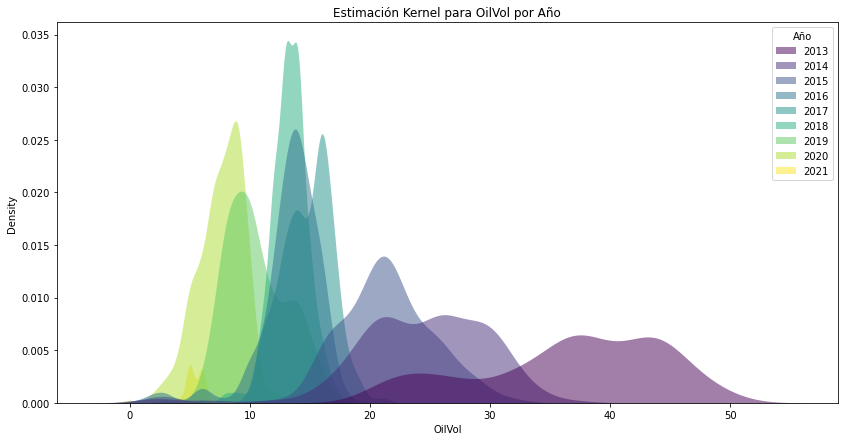

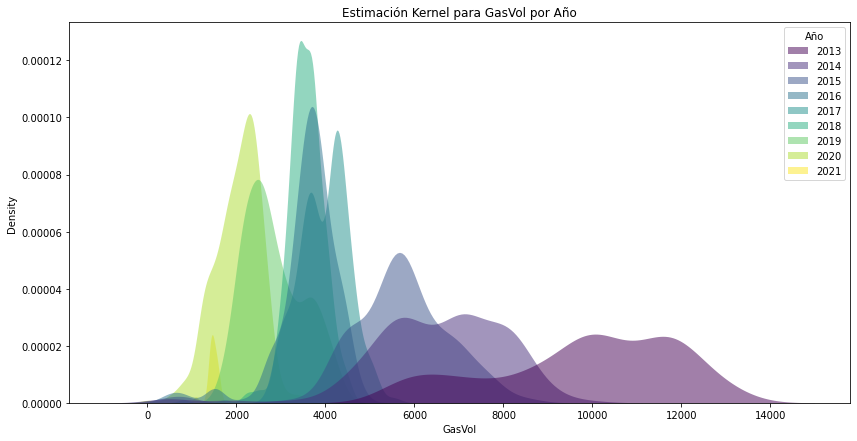

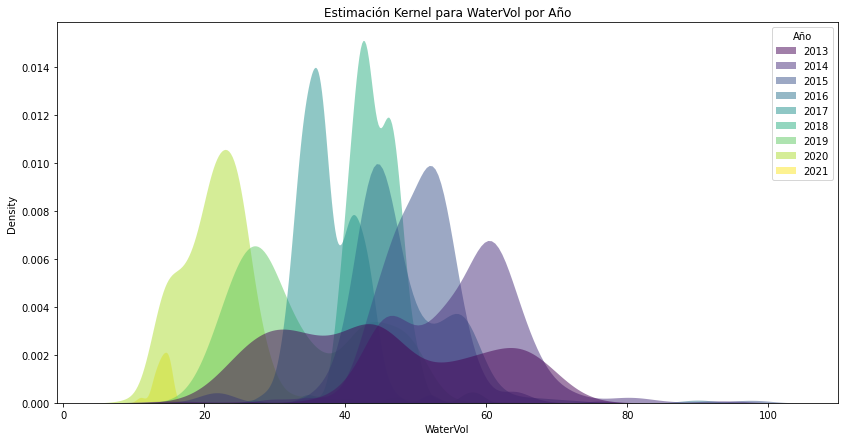

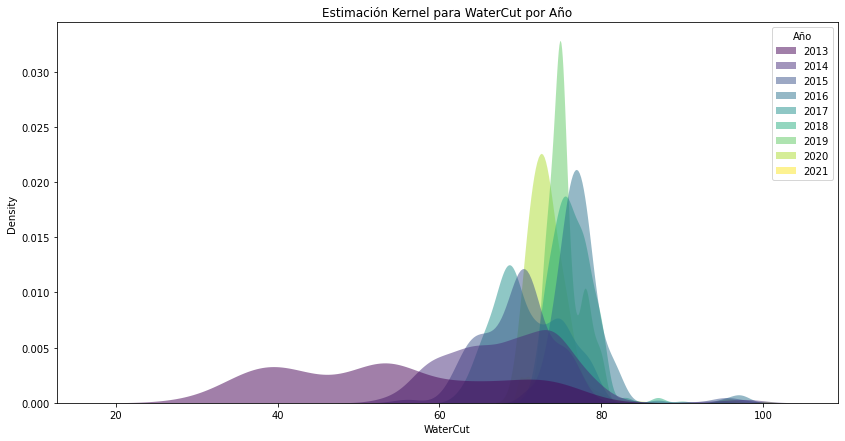

In [16]:
datos2['Año'] = datos2['Fecha'].dt.year

lista_2_plot = ['OilVol', 'GasVol', 'WaterVol', 'WaterCut']
for variable in lista_2_plot:
    fig, ax = plt.subplots(figsize=(14, 7))
    sns.kdeplot(data=datos2, x=variable, hue='Año', fill=True, alpha=0.5, linewidth=0, palette='viridis')
    ax.set_title(f'Estimación Kernel para {variable} por Año')
    plt.show()

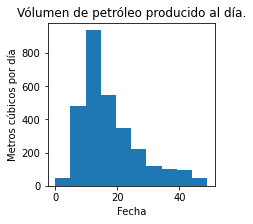

In [17]:
rcParams['figure.figsize'] = 3, 3
plt.hist(datos['OilVol'])
plt.title('Vólumen de petróleo producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

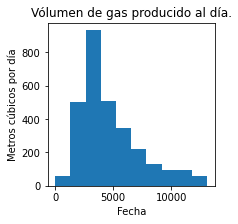

In [18]:
plt.hist(datos['GasVol'])
plt.title('Vólumen de gas producido al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

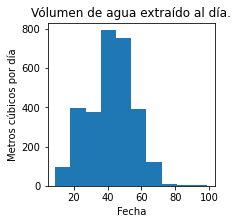

In [19]:
plt.hist(datos['WaterVol'])
plt.title('Vólumen de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()

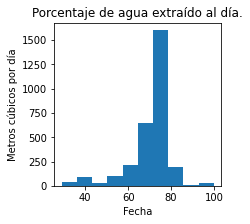

In [20]:
plt.hist(datos['WaterCut'])
plt.title('Porcentaje de agua extraído al día.')
plt.xlabel('Fecha')
plt.ylabel('Metros cúbicos por día')
plt.show()
#

# Funciones

## Periodograma

Esta función sirve para detectar el período de una posible componente estacional determinística

In [21]:
# Función periodograma
def periodograma(serie, frecuencia = 70):
    """Serie : Introduzcar un objeto tipo series de pandas
        frecuencia(opcional): introduzca el número de indices de frecuencia que desea ver en el eje x (70 por defecto)"""
    f, Pxx_den=sp.signal.periodogram(serie)
    plt.plot(f[0:frecuencia], Pxx_den[0:frecuencia])
    for i in range(4):
        indice=np.argmax(Pxx_den, axis=0)
        print(f'El valor máximo no. {i+1} en el que se maximiza el periodograma es en el indice {indice} ')
        frecuencia_max=f[indice]
        print(f'La frecuencia es: x={frecuencia_max} con valor de periodograma y={Pxx_den[indice]} ')
        print(f'El período es: {1/frecuencia_max} días')
        print(f'Lo cual corresponde a {round(1/frecuencia_max / 30,3)} meses\n')
        f=np.delete(f,indice)
        Pxx_den=np.delete(Pxx_den,indice)
        plt.axvline(x=frecuencia_max,color='red')
    plt.show()
    return 
    

## Ajuste tendencia vía Kernel

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

def TendKer(serie, ancho, predict_steps=0):
    """
    Esta función ajusta una regresión Kernel a la serie en función del tiempo y la gráfica.
    La regresión usa un Kernel Gaussiano y la regresión es de tipo local.
    Además, obtiene la serie sin la tendencia ajustada.
    
    Parameters:
    - serie: Objeto tipo series de pandas,
    - ancho: Ajusta el ancho de banda de la regresión, a mayor ancho menos suavidad,
    - predict_steps: Número de pasos futuros para los que se desea predecir
    
    Returns:
    - NoTendserie: Serie sin la tendencia ajustada
    - future_predictions: Predicciones de los valores futuros si predict_steps > 0
    """
    
    n = serie.shape[0]
    kde = KernelReg(endog=serie, exog=np.arange(n), var_type='c', bw=[ancho], reg_type='lc')
    
    # Fit the model to the existing data
    estimator, _ = kde.fit(np.arange(n))
    estimator = np.reshape(estimator, n)
    
    # Plot the original series and the estimated trend
    plt.plot(serie, label='Original Series')
    plt.plot(serie.index, estimator, color='red', label='Kernel Trend')
    plt.title(f'Estimación Kernel de {serie.name} con bw={ancho}')
    plt.legend()
    plt.show()
    
    # Remove trend from the series
    NoTendserie = serie - estimator
    
    # Predict future values if requested
    future_predictions = None
    if predict_steps > 0:
        future_x = np.arange(n, n + predict_steps)
        future_predictions, _ = kde.fit(future_x)
        future_predictions = np.reshape(future_predictions, predict_steps)
    return NoTendserie, future_predictions

# Ejemplo de uso:
# NoTendserie, future_pred = TendKer(your_series, ancho=5, predict_steps=10)


## Ajuste de tendencia vía LOWESS

In [23]:
def TendLOWESS (serie, prop):
    """Esta función ajusta una regresión LOWESS no robusta a la serie.
    Además obtiene la serie sin la tendencia ajustada.
        serie: Objeto tipo series de pandas
        prop: Proporción de punto que se usarán para la estimación local, a mayor proporción menos suavidad"""
    from statsmodels.nonparametric.smoothers_lowess import lowess
    n = serie.shape[0]
    lowess_serie = lowess(serie, exog= np.arange(n), is_sorted=True, frac=prop, it=0)
    # lowess obtiene una matriz; la primera columna hace referencia al índice en flotante, y la segunda a la estimación 
    y = list(zip(*lowess_serie))[1]
    NoTendserie = serie - y
    # Gráficos
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación LOWESS de {serie.name} con frac = {prop}')
    return NoTendserie
    

## Ajuste tendencia STL

In [24]:
def TendSTL(serie):
    ####Descomposición usando filtros
    from statsmodels.tsa.seasonal import seasonal_decompose
    from matplotlib import pyplot
    
    ###También se puede hacer vía STL###
    # Descomponer la serie de tiempo con un periodo de 365 días (para estacionalidad anual)
    result = seasonal_decompose(serie, model='additive', extrapolate_trend=6, period=365)
    
    # Graficar los resultados de la descomposición
    # desc_OilVol = result.plot()
    # pyplot.sho
    y = result.trend
    NoTendserie = serie - y
    # Gráfico
    plt.plot(serie)
    plt.plot(serie.index, y, color = 'red')
    plt.title(f'Estimación MA de {serie.name} de forma aditiva')
    return NoTendserie

# Análisis descriptivo de las series

## Volumen de petróleo

In [25]:
OilVol = datos.loc['2013-01-01':'2018-12-31','OilVol']

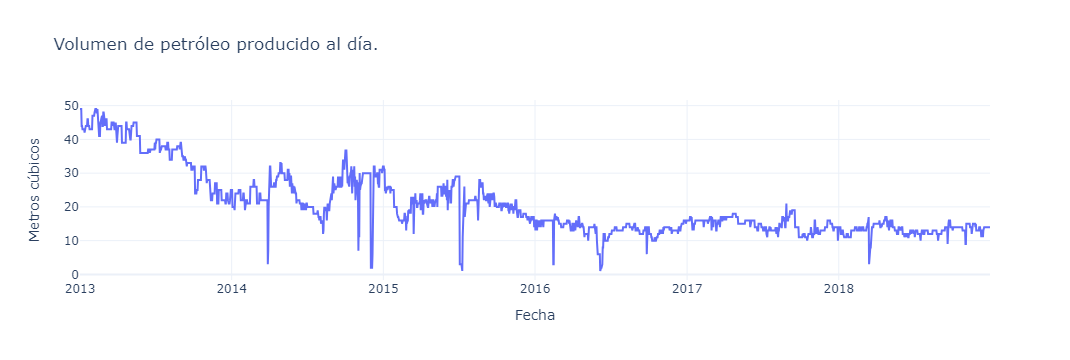

In [26]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y=OilVol)])
fig.update_layout(title_text="Volumen de petróleo producido al día.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos',template = "plotly_white")


### Ajuste tendencia  

Se puede ver que la serie presenta una componente de tendencia, en particular es decreciente y tiene sentido en el contexto en que estamos.

#### STL

Vamos a usar la componente de tendencia que se estima por medio del filtro STL.

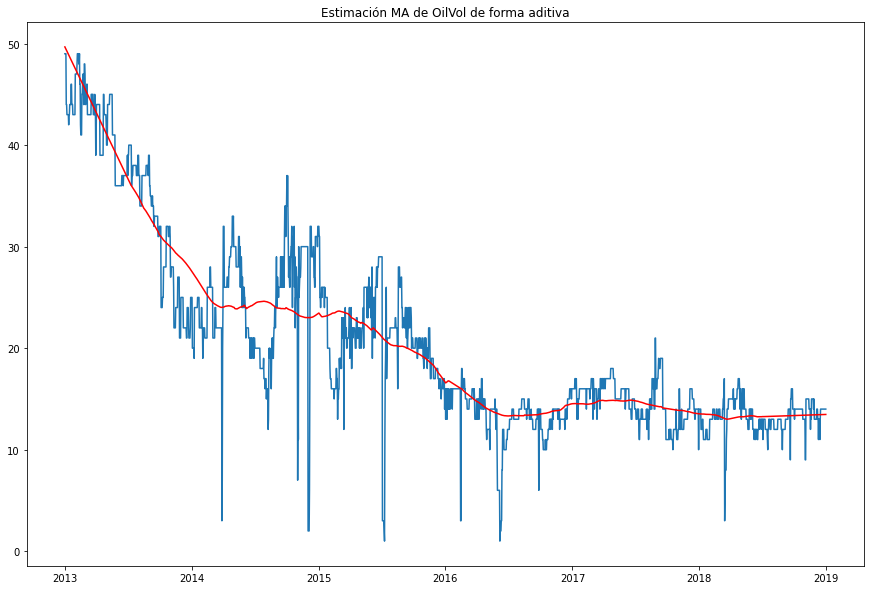

In [27]:
rcParams['figure.figsize'] = 15, 10

NoTen_OilVol_MA = TendSTL(OilVol)

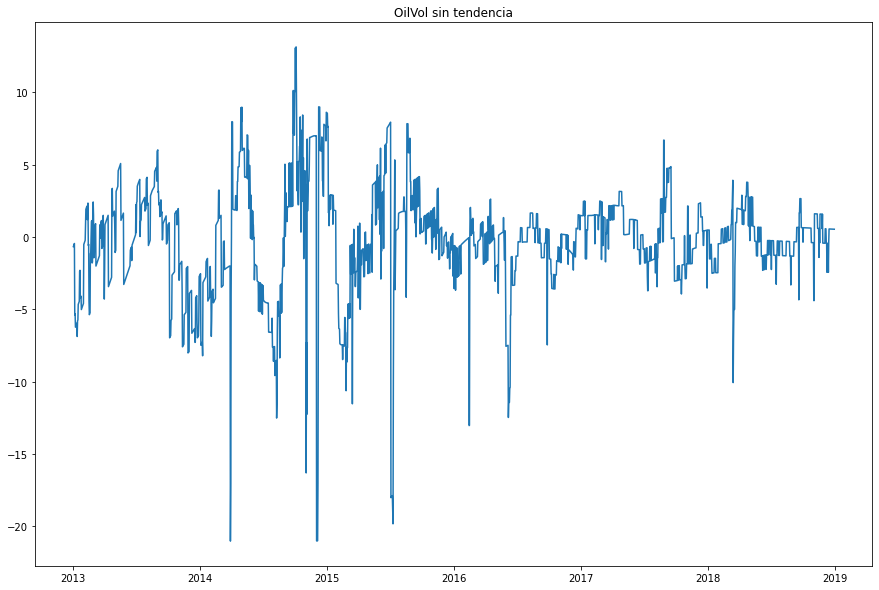

In [28]:
# Serie sin tendencia
plt.plot(NoTen_OilVol_MA)
plt.title('OilVol sin tendencia')
plt.show()

#### Kernel

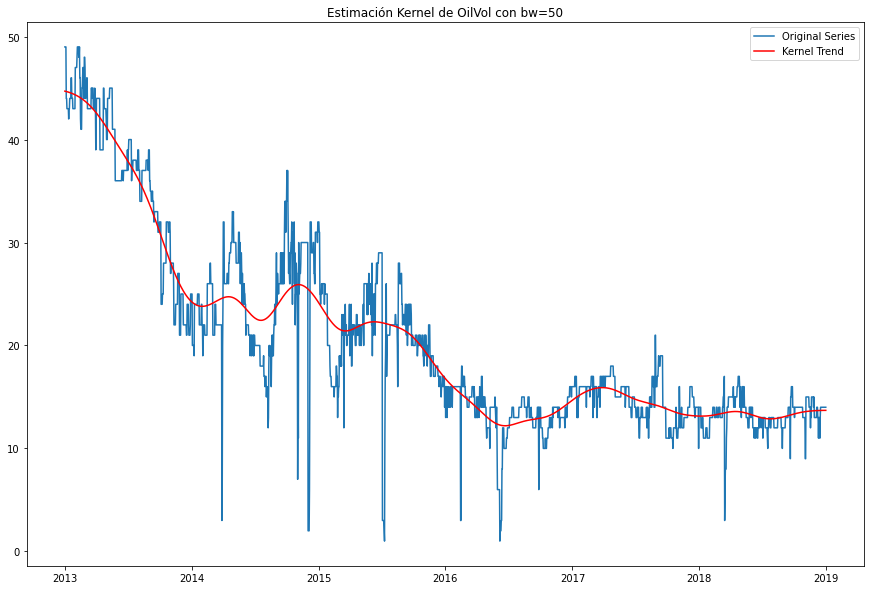

In [29]:
NoTen_OilVol_Kernel, predictedTen = TendKer(OilVol,ancho=50)

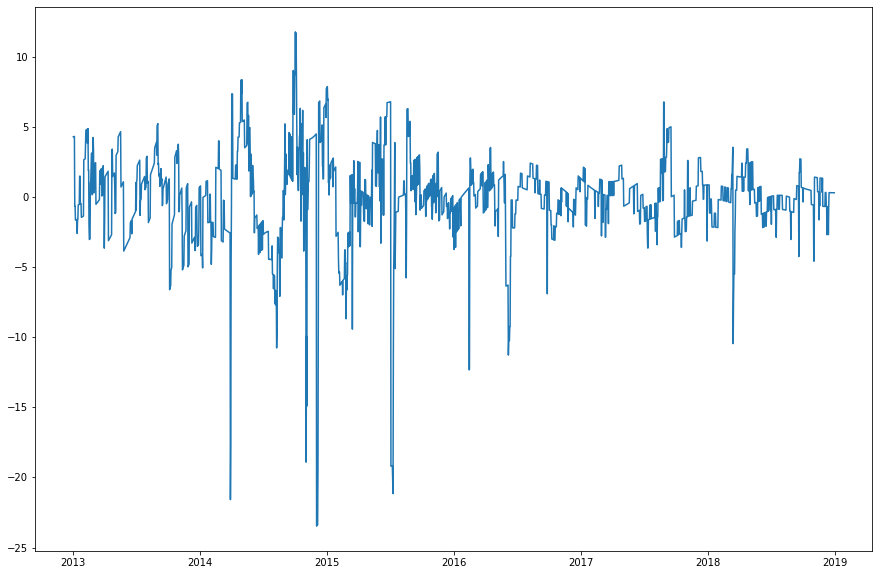

In [30]:
plt.plot(NoTen_OilVol_Kernel)

#### LOWESS

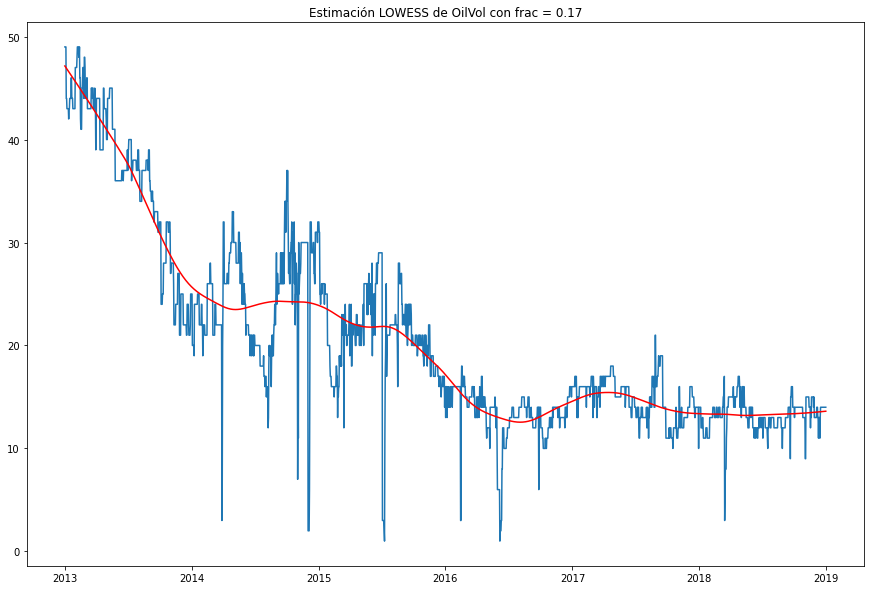

In [31]:
NoTen_OilVol_LOWESS = TendLOWESS(OilVol,prop=0.17)

### Detección estacionalidad

Se hará uso del periodograma y la función de autocorrelación para determinar si existe alguna componente estacional.

Se usará la serie sin tendencia ajustada vía Kernel, pues es la que mejor estabiliza la seria para identificar los rezagos más significativos.

El valor máximo no. 1 en el que se maximiza el periodograma es en el indice 18 
La frecuencia es: x=0.008215426745778184 con valor de periodograma y=1018.2305610428987 
El período es: 121.72222222222221 días
Lo cual corresponde a 4.057 meses

El valor máximo no. 2 en el que se maximiza el periodograma es en el indice 26 
La frecuencia es: x=0.012323140118667275 con valor de periodograma y=766.5410190315653 
El período es: 81.14814814814815 días
Lo cual corresponde a 2.705 meses

El valor máximo no. 3 en el que se maximiza el periodograma es en el indice 10 
La frecuencia es: x=0.004564125969876769 con valor de periodograma y=639.5703227488897 
El período es: 219.1 días
Lo cual corresponde a 7.303 meses

El valor máximo no. 4 en el que se maximiza el periodograma es en el indice 48 
La frecuencia es: x=0.02327704244637152 con valor de periodograma y=522.5977002737482 
El período es: 42.96078431372549 días
Lo cual corresponde a 1.432 meses



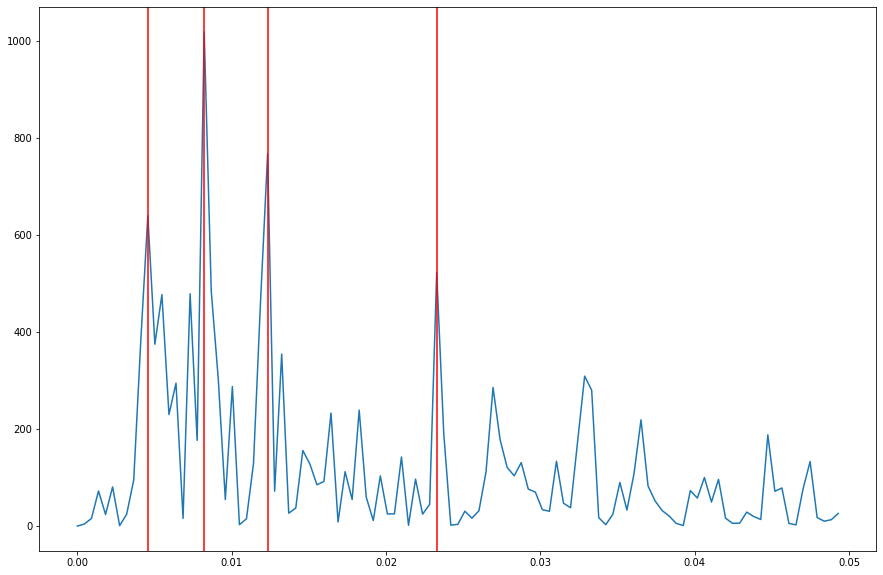

In [32]:
periodograma(NoTen_OilVol_Kernel, 109)

La serie no tiene presencia de componente estacional, pues los períodos no son armónicos y se corroboró en R con un mapa de calor. Por lo tanto las series subsecuentes tampoco tendrán esta componente

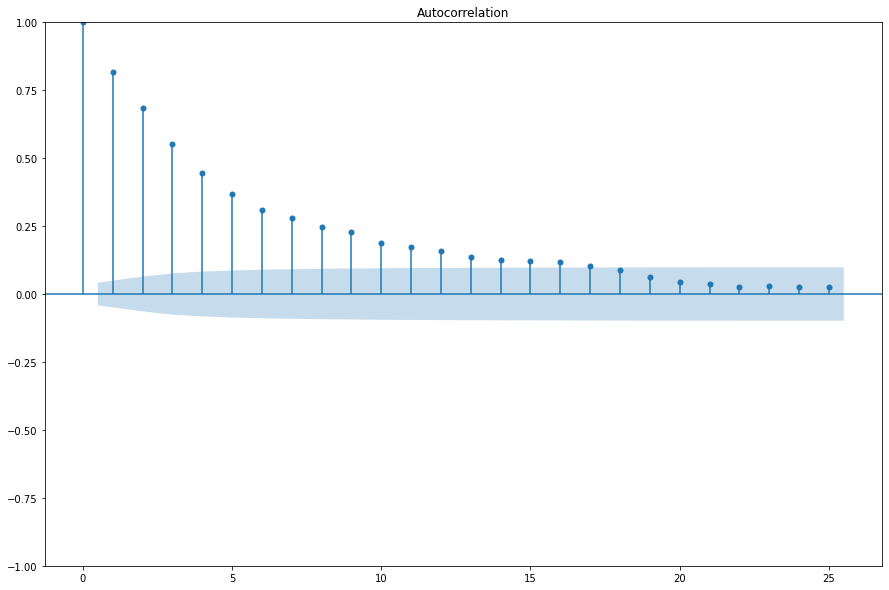

In [33]:
plot_acf(NoTen_OilVol_Kernel, lags=25)
plt.show()

Se tomarán 17 retardos de la variable para hacer la predicción de un año en una red neuronal

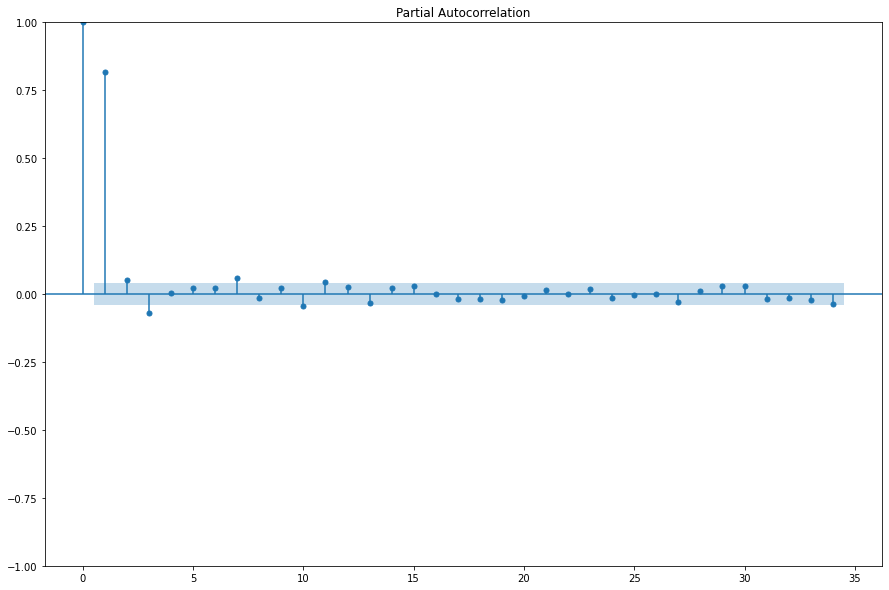

In [34]:
plot_pacf(NoTen_OilVol_Kernel)
plt.show()

La primera autocorrelación parcial es muy cercana a 1, lo cual sugiera presencia de raíz unitaria

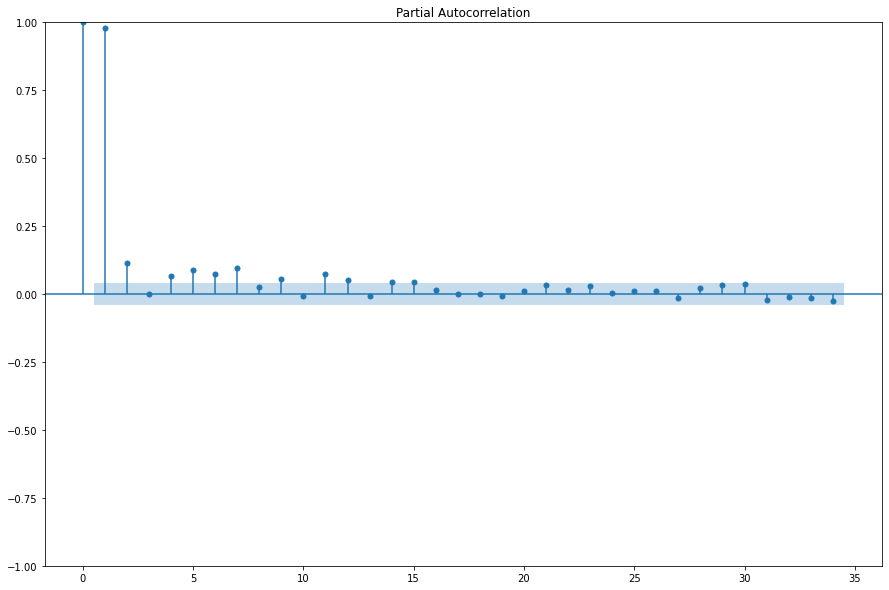

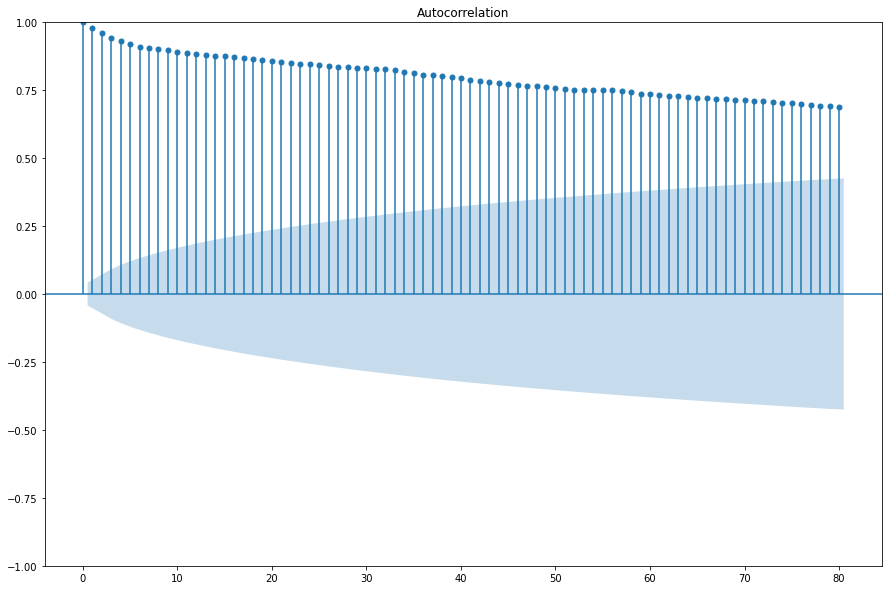

In [35]:
plot_pacf(OilVol)
plot_acf(OilVol,lags=80)
plt.show()

### Modelado ARIMA

Dado que la serie no tiene una componente estacional, pero si la componente de tendencia entonces vamos a ajuster un modelo ARIMA. 

Con base a la función de autocorrelación parcial de la serie sin diferenciar, vemos que el primer rezago tiene una correlación muy alta, lo cual sugiere la presencia de raíz unitaria. Se confirmará en la celda siguiente.

Primero vamos a realizar la prueba de presencia de raíz unitaria de Dickey y Fuller. 
Se considerarán los primeros 14 rezagos y una regresión con drift.

In [36]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(OilVol,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -2.783880
P-value: 0.060614
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.52
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.73e-30
Time:                        20:24:02   Log-Likelihood:                -4406.2
No. Observations:                2176   AIC:                             8844.
Df Residuals:                    2160   BIC:                             8935.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0122      0.004     -2.784      0.005      -0.021      -0.004
x2            -0.1741      0.022     -8.040      0.000      -0.217      -0.132
x3            -0.0607      0.022     -2.768      0.006      -0.104      -0.018
x4            -0.1328      0.022     -6.049      0.000      -0.176      -0.090
x5            -0.1349      0.022     -6.112      0.000      -0.178      -0.092
x6            -0.1314      0.022     -5.940      0.000      -0.175      -0.088
x7            -0.1436      0.022     -6.440      0.000      -0.187      -0.100
x8            -0.0724      0.022     -3.232      0.001      -0.116      -0.028
x9            -0.0923      0.022     -4.120      0.000      -0.136      -0.048
x10           -0.0293      0.022     -1.316      0.188      -0.073       0.014
x11           -0.1080      0.022     -4.900      0.000      -0.151      -0.065
x12           -0.0708      0.022     -3.232      0.001      -0.114      -0.028
x13           -0.0140      0.022     -0.643      0.520      -0.057       0.029
x14           -0.0650      0.022     -2.994      0.003      -0.108      -0.022
x15           -0.0599      0.021     -2.800      0.005      -0.102      -0.018
const          0.2169      0.098      2.216      0.027       0.025       0.409
==============================================================================
Omnibus:                     1864.869   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312619.091
Skew:                          -3.318   Prob(JB):                         0.00
Kurtosis:                      61.344   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [37]:
OilVold = OilVol.diff()
OilVold.dropna(inplace=True)

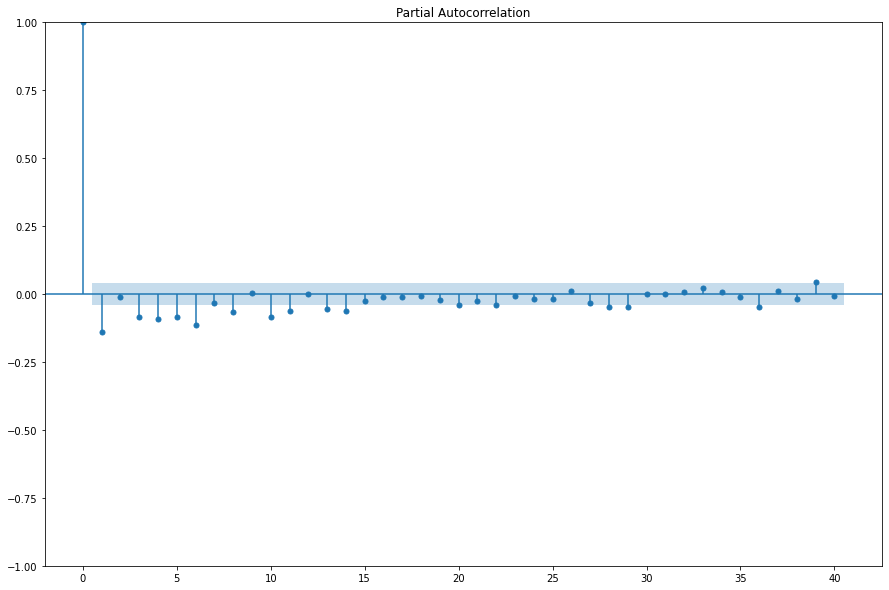

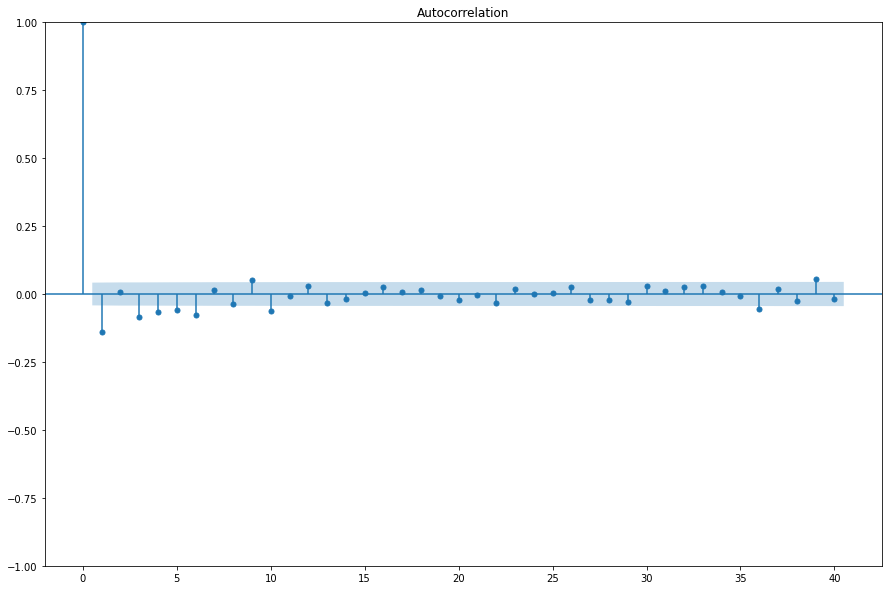

In [38]:
plot_pacf(OilVold, lags=40)
plot_acf(OilVold, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [39]:
from pmdarima.arima import auto_arima

adf = adfuller(OilVold,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(OilVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -16.994062
P-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.52
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.73e-30
Time:                        20:24:04   Log-Likelihood:                -4406.2
No. Observations:                2176   AIC:                             8844.
Df Residuals:                    2160   BIC:                             8935.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0122      0.004     -2.784      0.005      -0.021      -0.004
x2            -0.1741      0.022     -8.040      0.000      -0.217      -0.132
x3            -0.0607      0.022     -2.768      0.006      -0.104      -0.018
x4            -0.1328      0.022     -6.049      0.000      -0.176      -0.090
x5            -0.1349      0.022     -6.112      0.000      -0.178      -0.092
x6            -0.1314      0.022     -5.940      0.000      -0.175      -0.088
x7            -0.1436      0.022     -6.440      0.000      -0.187      -0.100
x8            -0.0724      0.022     -3.232      0.001      -0.116      -0.028
x9            -0.0923      0.022     -4.120      0.000      -0.136      -0.048
x10           -0.0293      0.022     -1.316      0.188      -0.073       0.014
x11           -0.1080      0.022     -4.900      0.000      -0.151      -0.065
x12           -0.0708      0.022     -3.232      0.001      -0.114      -0.028
x13           -0.0140      0.022     -0.643      0.520      -0.057       0.029
x14           -0.0650      0.022     -2.994      0.003      -0.108      -0.022
x15           -0.0599      0.021     -2.800      0.005      -0.102      -0.018
const          0.2169      0.098      2.216      0.027       0.025       0.409
==============================================================================
Omnibus:                     1864.869   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           312619.091
Skew:                          -3.318   Prob(JB):                         0.00
Kurtosis:                      61.344   Cond. No.                         55.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=10**

In [40]:
auto_OilVol = auto_arima(OilVold,start_p=0,d=0, start_q= 0, max_p=15, max_q=10, max_order=15,
                         seasonal=False,information_criterion='aic')

In [41]:
auto_OilVol.order

(3, 0, 1)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(3,1). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [42]:
import statsmodels.api as smapi
OilVolARIMA = smapi.tsa.SARIMAX(OilVol,order=(3,1,1),trend='c')

In [43]:
ajusteOilVol = OilVolARIMA.fit()

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Realizamos la predicción a 2 años con un intervalo de predicción al 95% 

In [44]:
salforecast=ajusteOilVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosOilVol=salforecast.predicted_mean
print(pronosticosOilVol)
print(ICforecast95)

2019-01-01    13.891607
2019-01-02    13.807195
2019-01-03    13.729747
2019-01-04    13.669218
2019-01-05    13.619957
                ...    
2020-12-26     2.844688
2020-12-27     2.829868
2020-12-28     2.815048
2020-12-29     2.800228
2020-12-30     2.785408
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower OilVol  upper OilVol
2019-01-01     10.289652     17.493562
2019-01-02      9.177686     18.436704
2019-01-03      8.343065     19.116429
2019-01-04      7.827835     19.510601
2019-01-05      7.466535     19.773379
...                  ...           ...
2020-12-26    -22.847686     28.537062
2020-12-27    -22.879133     28.538870
2020-12-28    -22.910570     28.540667
2020-12-29    -22.941996     28.542453
2020-12-30    -22.973411     28.544228

[730 rows x 2 columns]


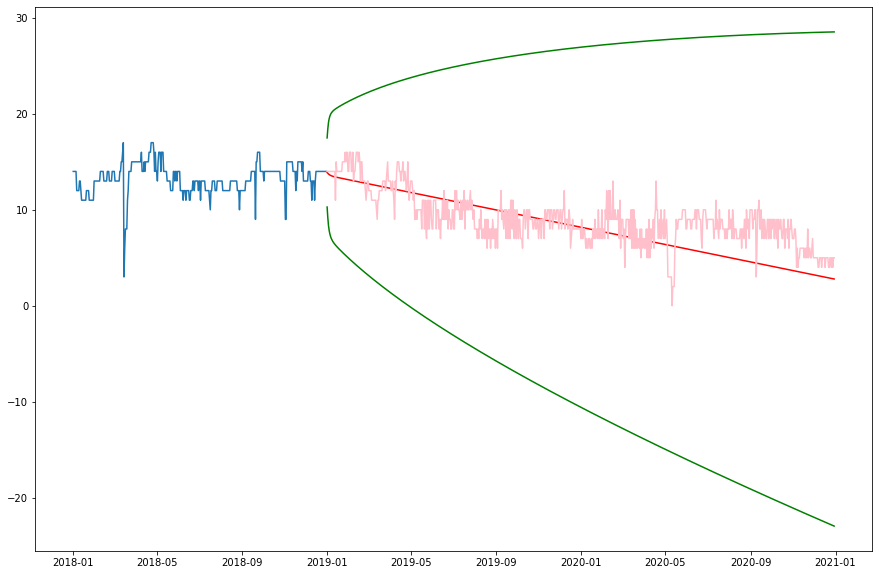

In [45]:
plt.plot(OilVol[-365:])
plt.plot(pronosticosOilVol, color='red')
plt.plot(ICforecast95['lower OilVol'],color='green')
plt.plot(ICforecast95['upper OilVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','OilVol'], color = 'pink')


In [46]:
print(ajusteOilVol.summary())

                               SARIMAX Results                                
Dep. Variable:                 OilVol   No. Observations:                 2191
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -4440.414
Date:                Fri, 01 Nov 2024   AIC                           8892.828
Time:                        20:24:27   BIC                           8926.978
Sample:                    01-01-2013   HQIC                          8905.309
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0035      0.003     -1.127      0.260      -0.010       0.003
ar.L1          0.7461      0.014     54.800      0.000       0.719       0.773
ar.L2          0.1008      0.013      8.049      0.0

## Volumen de gas producido

In [47]:
GasVol = datos.loc['2013-01-01':'2018-12-31','GasVol']

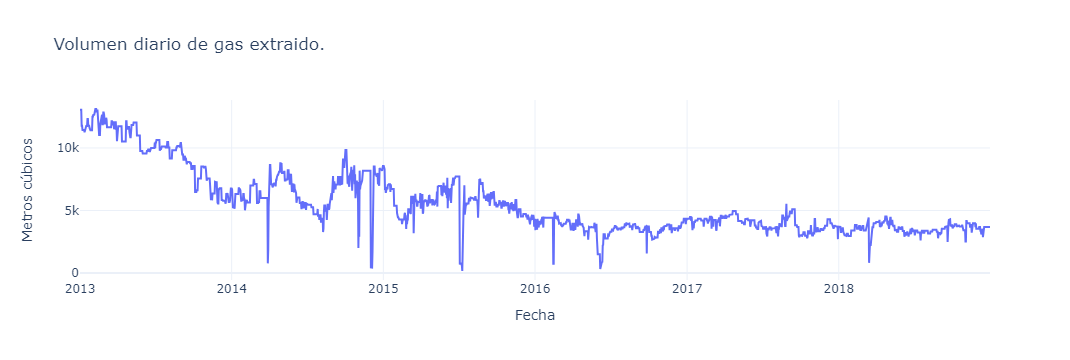

In [48]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= GasVol)])
fig.update_layout(title_text="Volumen diario de gas extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos',template = "plotly_white")


### Modelado ARIMA

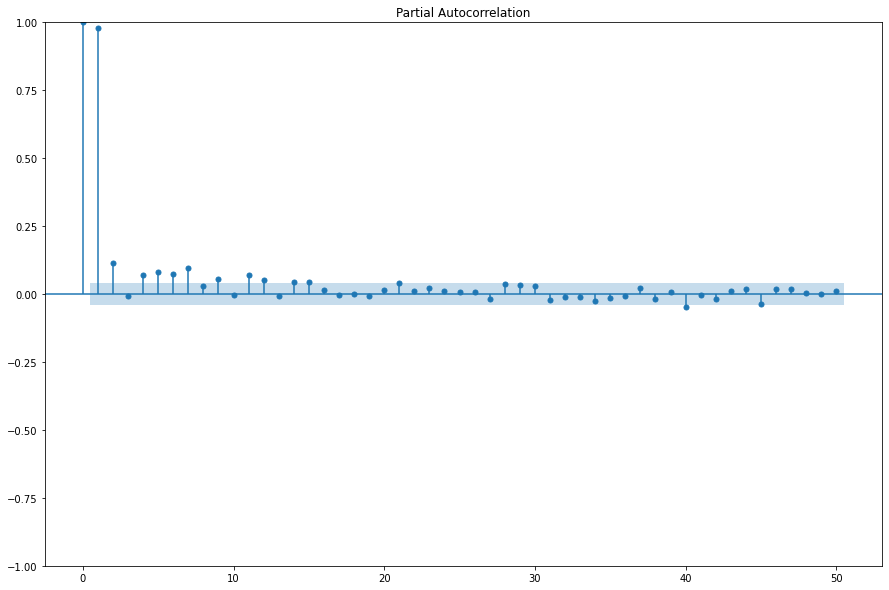

In [49]:
plot_pacf(GasVol,lags=50)
plt.show()

A lo más 15 rezagos pueden ser significativos para la parte auto regresiva!

In [50]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(GasVol,maxlag=14,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(GasVol,regression="c",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -2.764874
P-value: 0.063469
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     12.16
Date:                Fri, 01 Nov 2024   Prob (F-statistic):           1.82e-29
Time:                        20:24:32   Log-Likelihood:                -16565.
No. Observations:                2176   AIC:                         3.316e+04
Df Residuals:                    2160   BIC:                         3.325e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0120      0.004     -2.765      0.006      -0.021      -0.003
x2            -0.1717      0.022     -7.928      0.000      -0.214      -0.129
x3            -0.0543      0.022     -2.477      0.013      -0.097      -0.011
x4            -0.1327      0.022     -6.048      0.000      -0.176      -0.090
x5            -0.1233      0.022     -5.589      0.000      -0.167      -0.080
x6            -0.1322      0.022     -5.985      0.000      -0.176      -0.089
x7            -0.1423      0.022     -6.394      0.000      -0.186      -0.099
x8            -0.0758      0.022     -3.388      0.001      -0.120      -0.032
x9            -0.0894      0.022     -4.001      0.000      -0.133      -0.046
x10           -0.0319      0.022     -1.437      0.151      -0.075       0.012
x11           -0.1036      0.022     -4.708      0.000      -0.147      -0.060
x12           -0.0701      0.022     -3.200      0.001      -0.113      -0.027
x13           -0.0127      0.022     -0.585      0.559      -0.055       0.030
x14           -0.0672      0.022     -3.095      0.002      -0.110      -0.025
x15           -0.0592      0.021     -2.765      0.006      -0.101      -0.017
const         57.5242     26.147      2.200      0.028       6.248     108.800
==============================================================================
Omnibus:                     1940.108   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           366817.224
Skew:                          -3.517   Prob(JB):                         0.00
Kurtosis:                      66.216   Cond. No.                     1.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

No se rechaza la hipótesis nula de raíz unitaria. Se diferncia la serie.

In [51]:
GasVold = GasVol.diff()
GasVold.dropna(inplace=True)

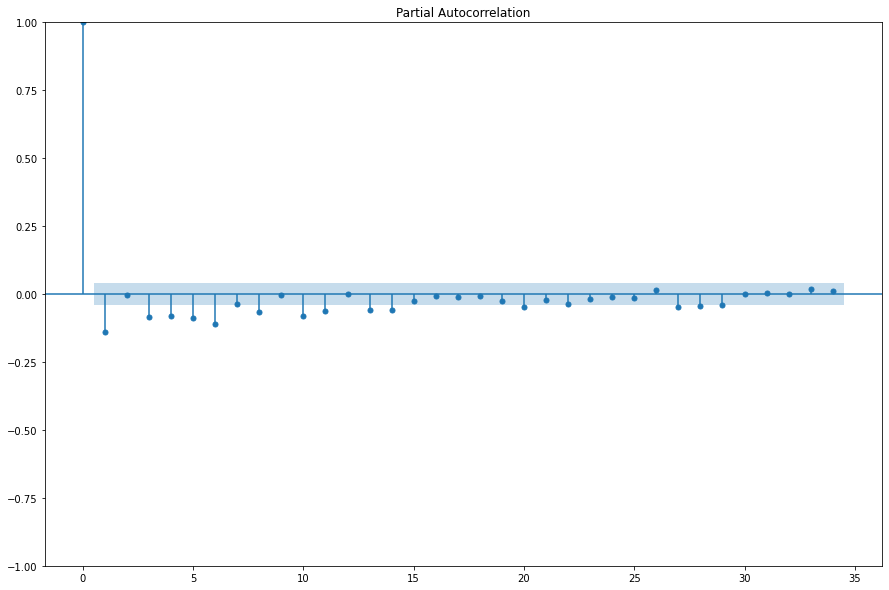

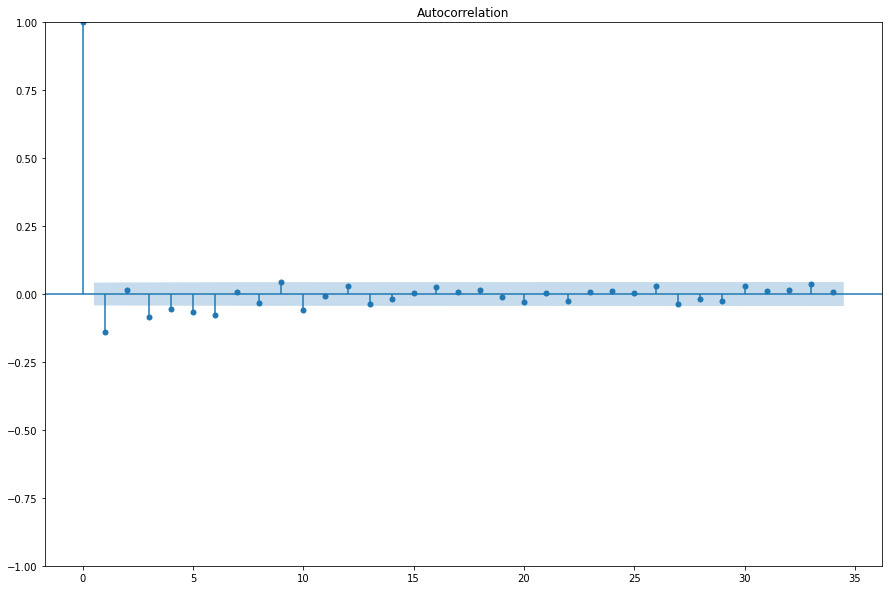

In [52]:
plot_pacf(GasVold)
plot_acf(GasVold)
plt.show()

In [53]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(GasVold,maxlag=13,regression='c',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(GasVold,regression="c",maxlag=13,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -17.698685
P-value: 0.000000
	1%: -3.433
	5%: -2.863
	10%: -2.567


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     225.4
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:24:34   Log-Likelihood:                -16568.
No. Observations:                2176   AIC:                         3.317e+04
Df Residuals:                    2161   BIC:                         3.325e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -2.3342      0.132    -17.699      0.000      -2.593      -2.076
x2             1.1541      0.126      9.174      0.000       0.907       1.401
x3             1.0921      0.119      9.167      0.000       0.858       1.326
x4             0.9520      0.112      8.506      0.000       0.732       1.171
x5             0.8218      0.104      7.881      0.000       0.617       1.026
x6             0.6835      0.097      7.079      0.000       0.494       0.873
x7             0.5356      0.088      6.088      0.000       0.363       0.708
x8             0.4548      0.079      5.757      0.000       0.300       0.610
x9             0.3609      0.070      5.184      0.000       0.224       0.497
x10            0.3251      0.060      5.380      0.000       0.207       0.444
x11            0.2180      0.051      4.236      0.000       0.117       0.319
x12            0.1451      0.042      3.428      0.001       0.062       0.228
x13            0.1301      0.033      3.936      0.000       0.065       0.195
x14            0.0608      0.021      2.837      0.005       0.019       0.103
const         -8.6285     10.561     -0.817      0.414     -29.340      12.083
==============================================================================
Omnibus:                     1949.610   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           371101.388
Skew:                          -3.545   Prob(JB):                         0.00
Kurtosis:                      66.583   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
auto_GasVol = auto_arima(GasVold,start_p=0,d=0, start_q= 0, max_p=14, max_q=10, max_order=14,
                         seasonal=False,information_criterion='aic', maxiter=250)

In [55]:
auto_OilVol.order

(3, 0, 1)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(3,1). Por lo tanto se puede establecer el modelo ARIMA(3,1,1).

In [56]:
import statsmodels.api as smapi
GasVolARIMA = smapi.tsa.SARIMAX(GasVol,order=(3,1,1),trend='c',time_varying_regression=True, mle_regression=False)

In [57]:
# ajusteGasVol = GasVolARIMA.fit(method='powell', maxiter=500)
ajusteGasVol = GasVolARIMA.fit(maxiter=2900)

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\6nico\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [58]:
salforecast=ajusteGasVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosGasVol=salforecast.predicted_mean
print(pronosticosGasVol)
print(ICforecast95)

2019-01-01    3660.624261
2019-01-02    3642.219456
2019-01-03    3625.136916
2019-01-04    3611.667536
2019-01-05    3600.591803
                 ...     
2020-12-26     883.058188
2020-12-27     879.315248
2020-12-28     875.572309
2020-12-29     871.829369
2020-12-30     868.086429
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower GasVol  upper GasVol
2019-01-01   2699.668676   4621.579846
2019-01-02   2404.535981   4879.902931
2019-01-03   2181.460066   5068.813767
2019-01-04   2044.326650   5179.008422
2019-01-05   1948.249888   5252.933718
...                  ...           ...
2020-12-26  -6114.800350   7880.916726
2020-12-27  -6123.081335   7881.711831
2020-12-28  -6131.359380   7882.503998
2020-12-29  -6139.634493   7883.293230
2020-12-30  -6147.906677   7884.079535

[730 rows x 2 columns]


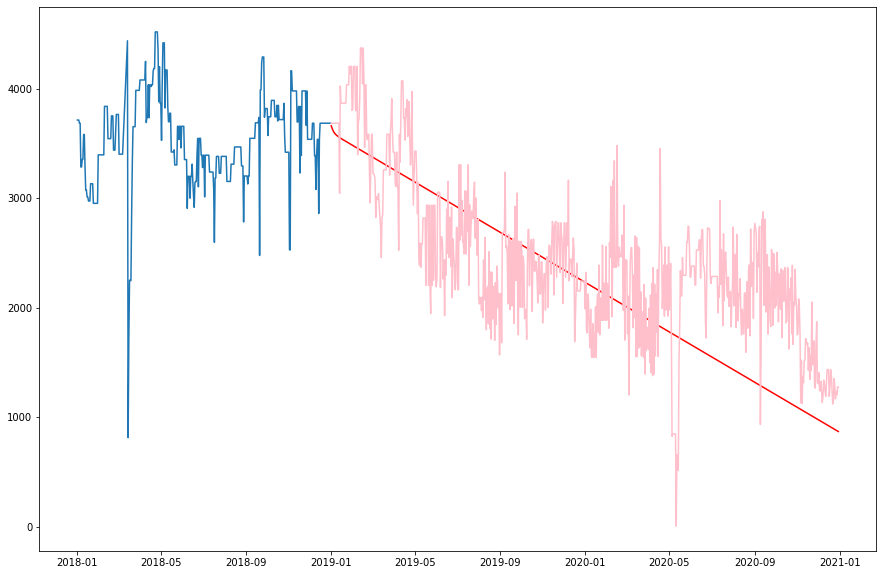

In [59]:
plt.plot(GasVol[-365:])
plt.plot(pronosticosGasVol, color='red')
# plt.plot(ICforecast95['lower GasVol'],color='green')
# plt.plot(ICforecast95['upper GasVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','GasVol'], color = 'pink')


## Volumen de agua extraida

In [60]:
WaterVol = datos.loc['2013-01-01':'2018-12-31','WaterVol']

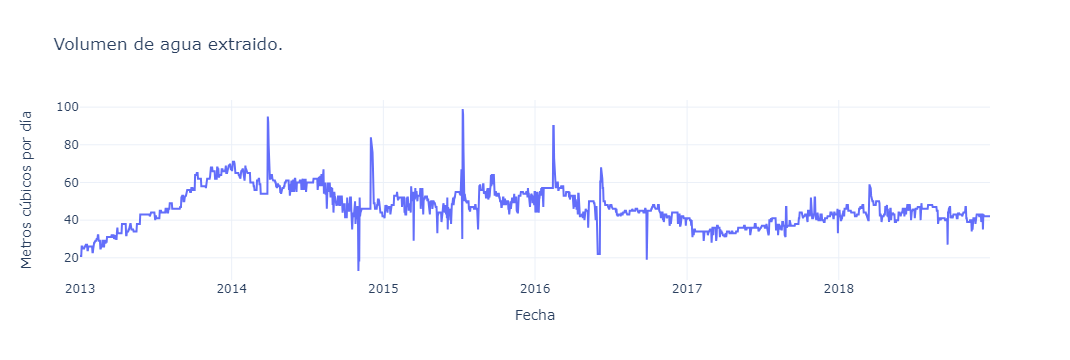

In [61]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= WaterVol)])
fig.update_layout(title_text="Volumen de agua extraido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Metros cúbicos por día',template = "plotly_white")


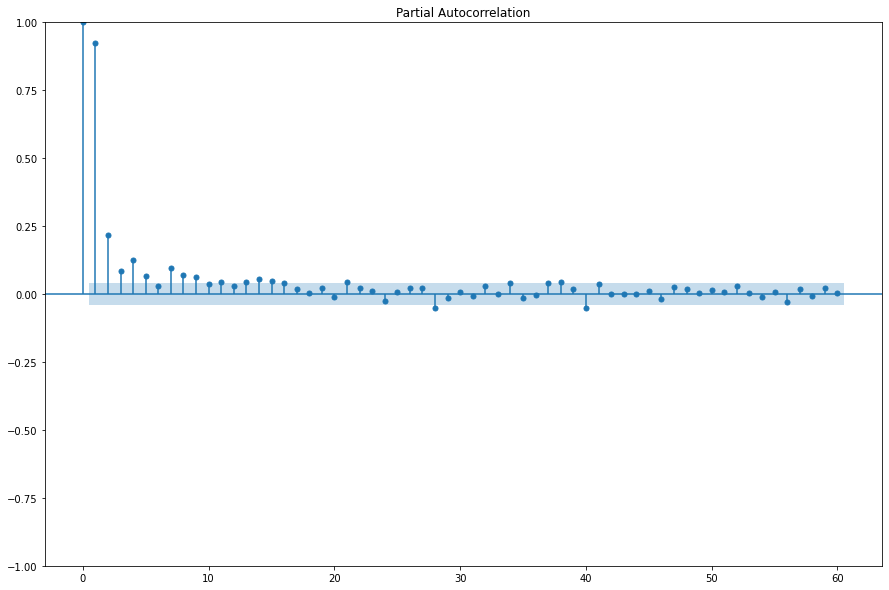

In [62]:
plot_pacf(WaterVol, lags=60)
plt.show()

### Modelado ARIMA

In [63]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(WaterVol,maxlag=15,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(WaterVol,regression="n",maxlag=15,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -0.299390
P-value: 0.576301
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.136
Method:                 Least Squares   F-statistic:                              22.39
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                    4.43e-61
Time:                        20:24:58   Log-Likelihood:                         -5871.1
No. Observations:                2175   AIC:                                  1.177e+04
Df Residuals:                    2159   BIC:                                  1.187e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0005      0.002     -0.299      0.765      -0.004       0.003
x2            -0.3531      0.022    -16.389      0.000      -0.395      -0.311
x3            -0.2267      0.023     -9.948      0.000      -0.271      -0.182
x4            -0.2494      0.023    -10.743      0.000      -0.295      -0.204
x5            -0.1781      0.024     -7.505      0.000      -0.225      -0.132
x6            -0.1538      0.024     -6.420      0.000      -0.201      -0.107
x7            -0.2057      0.024     -8.552      0.000      -0.253      -0.159
x8            -0.1679      0.024     -6.900      0.000      -0.216      -0.120
x9            -0.1474      0.024     -6.044      0.000      -0.195      -0.100
x10           -0.1164      0.024     -4.784      0.000      -0.164      -0.069
x11           -0.1121      0.024     -4.664      0.000      -0.159      -0.065
x12           -0.0910      0.024     -3.803      0.000      -0.138      -0.044
x13           -0.0992      0.024     -4.185      0.000      -0.146      -0.053
x14           -0.0948      0.023     -4.092      0.000      -0.140      -0.049
x15           -0.0733      0.023     -3.225      0.001      -0.118      -0.029
x16           -0.0474      0.021     -2.204      0.028      -0.089      -0.005
==============================================================================
Omnibus:                     1964.232   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           375330.141
Skew:                           3.594   Prob(JB):                         0.00
Kurtosis:                      66.952   Cond. No.                         30.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [64]:
WaterVold = WaterVol.diff()
WaterVold.dropna(inplace=True)

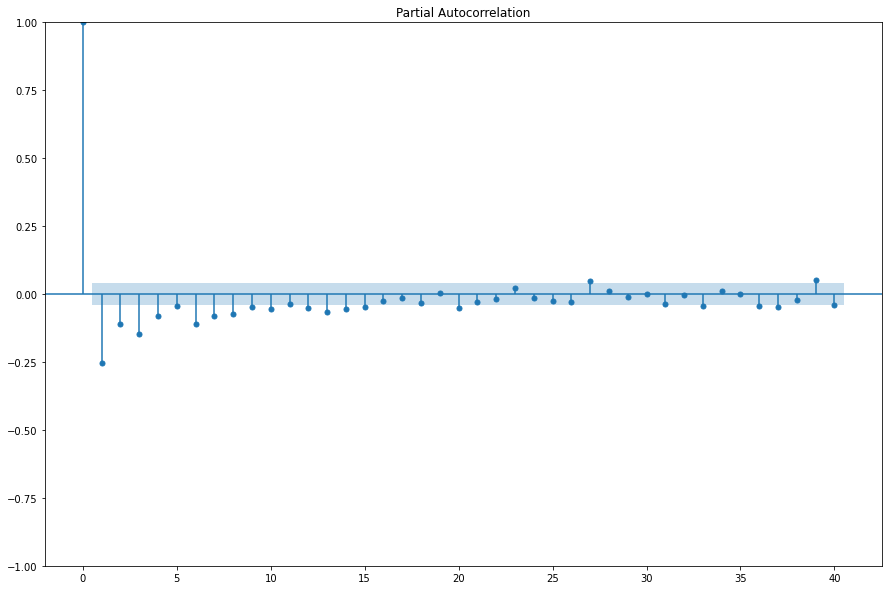

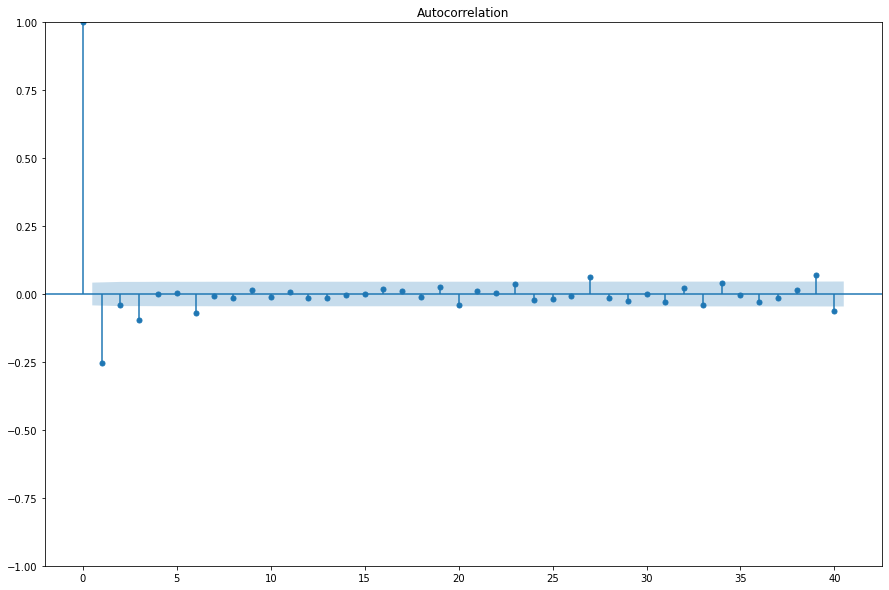

In [65]:
plot_pacf(WaterVold, lags=40)
plot_acf(WaterVold, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [66]:
from pmdarima.arima import auto_arima

adf = adfuller(WaterVold,maxlag=14,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(WaterVold,regression="n",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -18.130381
P-value: 0.000000
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.658
Model:                            OLS   Adj. R-squared (uncentered):              0.656
Method:                 Least Squares   F-statistic:                              276.9
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                        0.00
Time:                        20:25:00   Log-Likelihood:                         -5871.1
No. Observations:                2175   AIC:                                  1.177e+04
Df Residuals:                    2160   BIC:                                  1.186e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -3.3207      0.183    -18.130      0.000      -3.680      -2.961
x2             1.9671      0.176     11.158      0.000       1.621       2.313
x3             1.7400      0.168     10.374      0.000       1.411       2.069
x4             1.4902      0.158      9.411      0.000       1.180       1.801
x5             1.3117      0.148      8.859      0.000       1.021       1.602
x6             1.1576      0.137      8.444      0.000       0.889       1.426
x7             0.9515      0.126      7.574      0.000       0.705       1.198
x8             0.7833      0.113      6.905      0.000       0.561       1.006
x9             0.6356      0.101      6.301      0.000       0.438       0.833
x10            0.5189      0.088      5.889      0.000       0.346       0.692
x11            0.4065      0.076      5.372      0.000       0.258       0.555
x12            0.3153      0.063      5.025      0.000       0.192       0.438
x13            0.2159      0.049      4.376      0.000       0.119       0.313
x14            0.1209      0.036      3.352      0.001       0.050       0.192
x15            0.0475      0.021      2.210      0.027       0.005       0.090
==============================================================================
Omnibus:                     1963.606   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374974.014
Skew:                           3.592   Prob(JB):                         0.00
Kurtosis:                      66.922   Cond. No.                         55.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=3**

In [67]:
auto_WaterVol = auto_arima(WaterVold,start_p=0,d=0, start_q= 0, max_p=15, max_q=3, max_order=18,
                         seasonal=False,information_criterion='aic')

In [68]:
auto_WaterVol.order

(2, 0, 2)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(2,2). Por lo tanto se puede establecer el modelo ARIMA(2,1,2).

In [69]:
import statsmodels.api as smapi
WaterVolARIMA = smapi.tsa.SARIMAX(WaterVol,order=(2,1,2),trend='n')

In [70]:
# ajusteWaterVol = WaterVolARIMA.fit(method='cg', maxiter=30000000)
ajusteWaterVol = WaterVolARIMA.fit(maxiter=900)

Realizamos la predicción a 2 años con un intervalo de predicción al 95% 

In [71]:
salforecast=ajusteWaterVol.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosWaterVol=salforecast.predicted_mean
print(pronosticosWaterVol)
print(ICforecast95)

2019-01-01    41.950557
2019-01-02    41.922309
2019-01-03    41.901097
2019-01-04    41.887956
2019-01-05    41.878650
                ...    
2020-12-26    41.860243
2020-12-27    41.860243
2020-12-28    41.860243
2020-12-29    41.860243
2020-12-30    41.860243
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower WaterVol  upper WaterVol
2019-01-01       34.914791       48.986324
2019-01-02       33.561046       50.283571
2019-01-03       32.716573       51.085620
2019-01-04       32.266769       51.509143
2019-01-05       31.949869       51.807432
...                    ...             ...
2020-12-26        2.713045       81.007441
2020-12-27        2.687769       81.032717
2020-12-28        2.662509       81.057977
2020-12-29        2.637265       81.083221
2020-12-30        2.612038       81.108448

[730 rows x 2 columns]


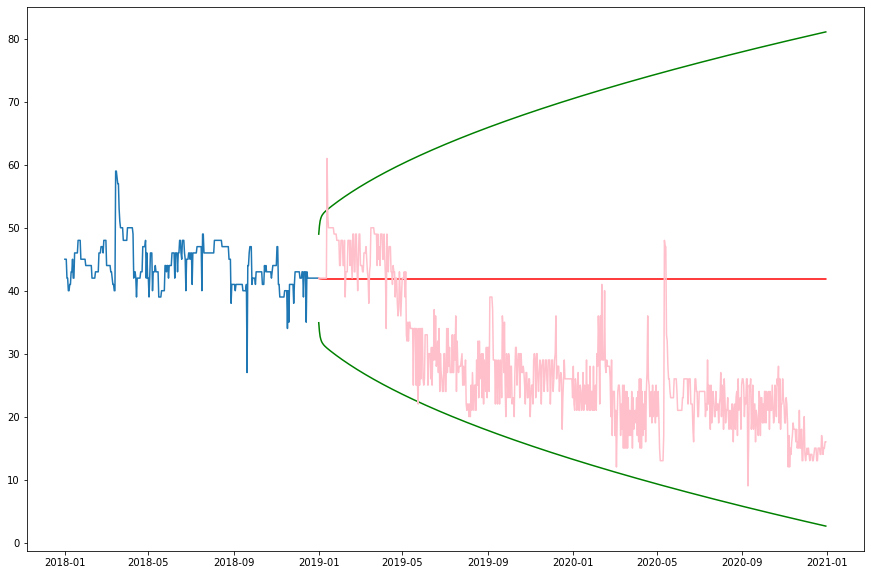

In [72]:
plt.plot(WaterVol[-365:])
plt.plot(pronosticosWaterVol, color='red')
plt.plot(ICforecast95['lower WaterVol'],color='green')
plt.plot(ICforecast95['upper WaterVol'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','WaterVol'], color = 'pink')


## Porcentaje de agua en líquido

In [73]:
WaterCut = datos.loc['2013-01-01':'2018-12-31','WaterCut']

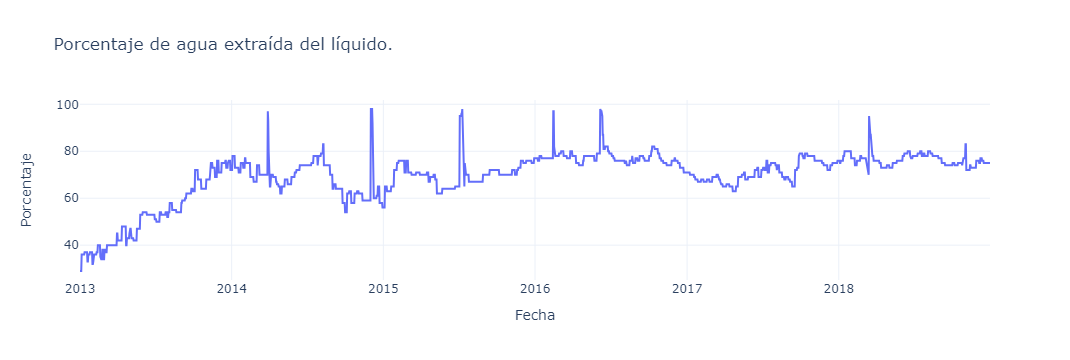

In [74]:
rcParams['figure.figsize'] = 15, 10
fig = go.Figure([go.Scatter(x=datos.index, y= WaterCut)])
fig.update_layout(title_text="Porcentaje de agua extraída del líquido.")
fig.update_layout(xaxis_title = 'Fecha', yaxis_title = 'Porcentaje',template = "plotly_white")


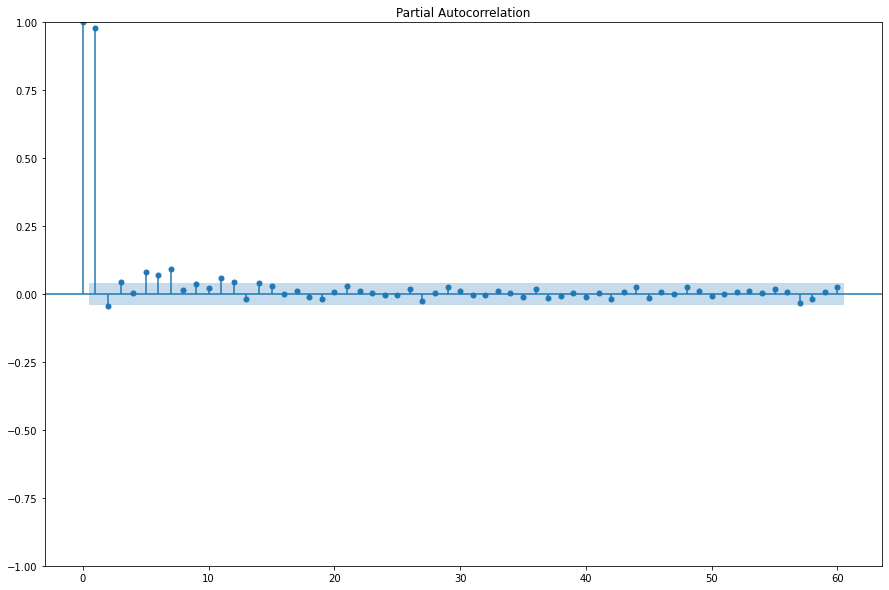

In [75]:
plot_pacf(WaterCut, lags=60)
plt.show()

### Modelado ARIMA

In [76]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(WaterCut,maxlag=14,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

adfstat, pvalue, critvalues, resstore=adfuller(WaterCut,regression="n",maxlag=14,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: 0.295352
P-value: 0.773604
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.052
Model:                            OLS   Adj. R-squared (uncentered):              0.045
Method:                 Least Squares   F-statistic:                              7.885
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                    1.41e-17
Time:                        20:25:14   Log-Likelihood:                         -4538.9
No. Observations:                2176   AIC:                                      9108.
Df Residuals:                    2161   BIC:                                      9193.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.001      0.295      0.768      -0.001       0.001
x2             0.0084      0.022      0.392      0.695      -0.034       0.051
x3            -0.0960      0.021     -4.470      0.000      -0.138      -0.054
x4            -0.0454      0.022     -2.106      0.035      -0.088      -0.003
x5            -0.1044      0.022     -4.847      0.000      -0.147      -0.062
x6            -0.1153      0.022     -5.339      0.000      -0.158      -0.073
x7            -0.1376      0.022     -6.341      0.000      -0.180      -0.095
x8            -0.0457      0.022     -2.091      0.037      -0.089      -0.003
x9            -0.0700      0.022     -3.203      0.001      -0.113      -0.027
x10           -0.0468      0.022     -2.154      0.031      -0.089      -0.004
x11           -0.0790      0.022     -3.661      0.000      -0.121      -0.037
x12           -0.0658      0.021     -3.066      0.002      -0.108      -0.024
x13            0.0079      0.021      0.369      0.712      -0.034       0.050
x14           -0.0558      0.021     -2.609      0.009      -0.098      -0.014
x15           -0.0430      0.021     -2.006      0.045      -0.085      -0.001
==============================================================================
Omnibus:                     3087.805   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1802924.957
Skew:                           7.887   Prob(JB):                         0.00
Kurtosis:                     143.130   Cond. No.                         50.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Con una confianza del 95% no rechazamos la hipóteis nula; se confirma la presencia de raíz unitaria.
Por lo tanto se realiza la diferencia de primer orden de la serie para luego ajustar un modelo **ARMA(p,q)**

In [77]:
WaterCutd = WaterCut.diff()
WaterCutd.dropna(inplace=True)

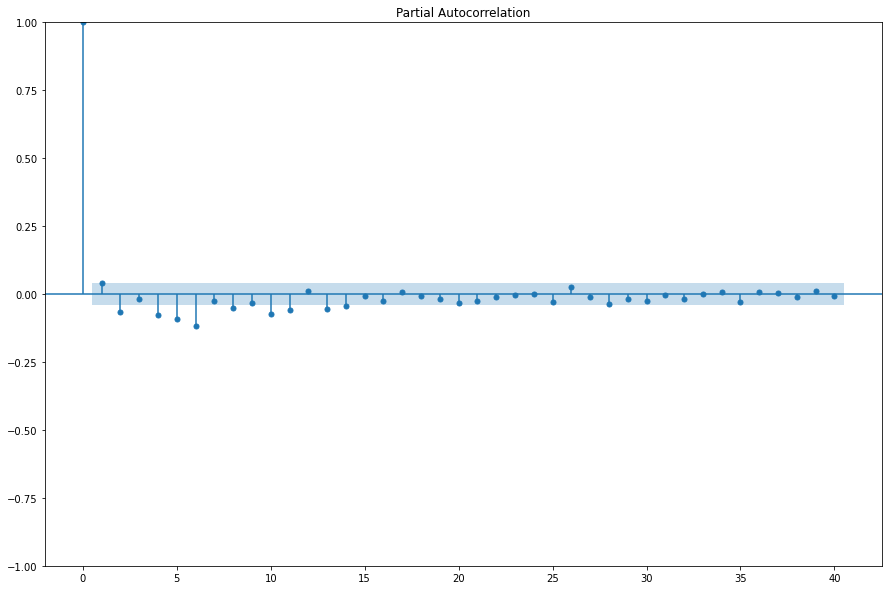

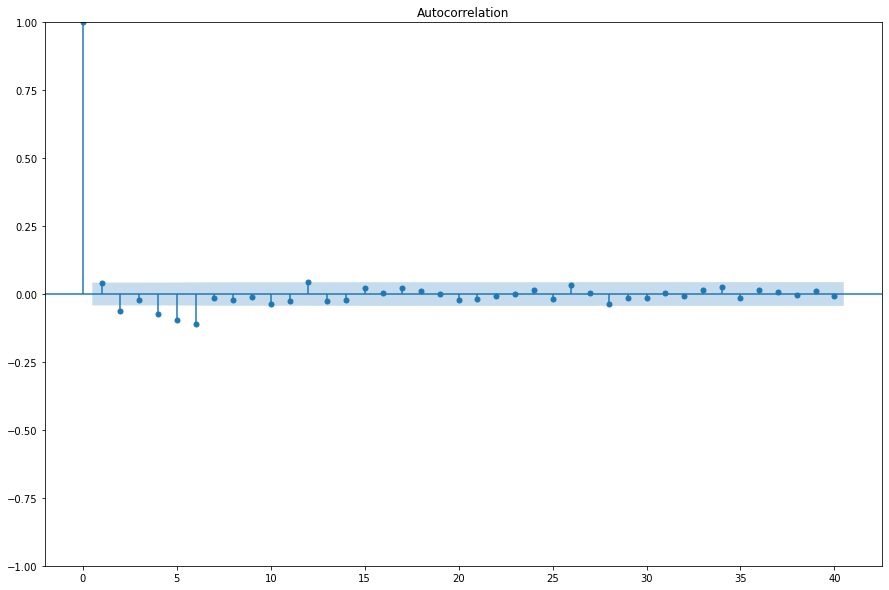

In [78]:
plot_pacf(WaterCutd, lags=40)
plot_acf(WaterCutd, lags=40)
plt.show()

Ya se puede ver que la PACF de la serie decrece muy rápido a 0. La ACF parece no mostrar signos de estacionalidad.

Se volve a realizar la prueba de Dickey y Fuller para determinar si hay que diferenciar de nuevo la serie.

In [79]:
from pmdarima.arima import auto_arima

adf = adfuller(WaterCutd,maxlag=13,regression='n',autolag=None)

print('ADF Statistic: %f' % adf[0])
print('P-value: %f' % adf[1])
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))
adfstat, pvalue, critvalues, resstore=adfuller(WaterCutd,regression="n",maxlag=13,autolag=None,store=True,regresults=True)####maxlag es importante
resstore.resols.summary()

ADF Statistic: -17.056398
P-value: 0.000000
	1%: -2.567
	5%: -1.941
	10%: -1.617


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.503
Method:                 Least Squares   F-statistic:                              158.1
Date:                Fri, 01 Nov 2024   Prob (F-statistic):                   4.41e-318
Time:                        20:25:16   Log-Likelihood:                         -4539.0
No. Observations:                2176   AIC:                                      9106.
Df Residuals:                    2162   BIC:                                      9186.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.8860      0.111    -17.056      0.000      -2.103      -1.669
x2             0.8946      0.105      8.522      0.000       0.689       1.100
x3             0.7988      0.100      8.024      0.000       0.604       0.994
x4             0.7536      0.093      8.071      0.000       0.571       0.937
x5             0.6494      0.087      7.449      0.000       0.478       0.820
x6             0.5344      0.081      6.608      0.000       0.376       0.693
x7             0.3969      0.074      5.359      0.000       0.252       0.542
x8             0.3514      0.067      5.254      0.000       0.220       0.483
x9             0.2816      0.059      4.755      0.000       0.165       0.398
x10            0.2350      0.052      4.521      0.000       0.133       0.337
x11            0.1562      0.045      3.473      0.001       0.068       0.244
x12            0.0905      0.038      2.380      0.017       0.016       0.165
x13            0.0985      0.030      3.274      0.001       0.040       0.158
x14            0.0429      0.021      2.001      0.046       0.001       0.085
==============================================================================
Omnibus:                     3088.017   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1803649.143
Skew:                           7.888   Prob(JB):                         0.00
Kurtosis:                     143.158   Cond. No.                         23.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Se rechaza la hipótesis nula de presencia de raíz unitaria; no hay que diferenciar más la serie.

Se ajustará el modelo **ARMA(p,q)** a la serie de primer diferencia ordinaria.

Con base en la PACF Y ACF de la serie diferenciada podemos establecer los ordenes máximo del modelo. Para la parte AR tenemos que **p=15** y para la parte MA establecemos **q=6**

In [80]:
auto_WaterCut = auto_arima(WaterCutd,start_p=0,d=0, start_q= 0, max_p=14, max_q=6, max_order=20,
                         seasonal=False,information_criterion='aic')

In [81]:
auto_WaterCut.order

(4, 0, 3)

El "mejor" modelo ARMA que minimiza el criterio AIC resulta ser un modelo ARMA(4,3). Por lo tanto se puede establecer el modelo ARIMA(4,1,3).

In [82]:
import statsmodels.api as smapi
WaterCutARIMA = smapi.tsa.SARIMAX(WaterCut,order=(4,1,3),trend='n')

In [83]:
ajusteWaterCut = WaterCutARIMA.fit(maxiter=1000000)

Realizamos la predicción a 2 años con un intervalo de predicción al 95% 

In [84]:
salforecast=ajusteWaterCut.get_forecast(steps=365 * 2)
ICforecast95=salforecast.conf_int(alpha=0.05)
pronosticosWaterCut=salforecast.predicted_mean
print(pronosticosWaterCut)
print(ICforecast95)

2019-01-01    75.013733
2019-01-02    75.019110
2019-01-03    75.032719
2019-01-04    75.055153
2019-01-05    75.070736
                ...    
2020-12-26    75.093537
2020-12-27    75.093537
2020-12-28    75.093537
2020-12-29    75.093537
2020-12-30    75.093537
Freq: D, Name: predicted_mean, Length: 730, dtype: float64
            lower WaterCut  upper WaterCut
2019-01-01       71.191029       78.836438
2019-01-02       69.604621       80.433598
2019-01-03       68.614237       81.451201
2019-01-04       67.865755       82.244551
2019-01-05       67.318308       82.823163
...                    ...             ...
2020-12-26       35.447009      114.740066
2020-12-27       35.420790      114.766285
2020-12-28       35.394589      114.792486
2020-12-29       35.368405      114.818670
2020-12-30       35.342238      114.844837

[730 rows x 2 columns]


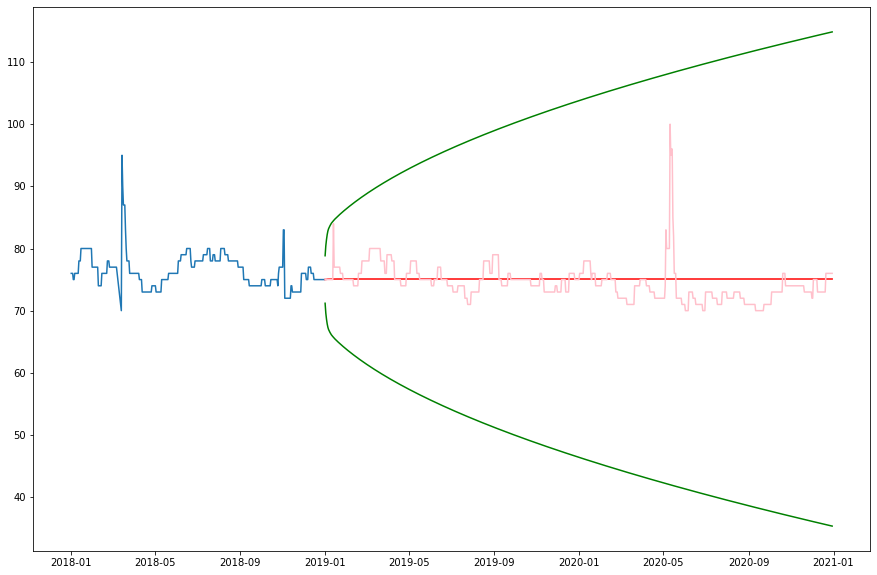

In [85]:
plt.plot(WaterCut[-365:])
plt.plot(pronosticosWaterCut, color='red')
plt.plot(ICforecast95['lower WaterCut'],color='green')
plt.plot(ICforecast95['upper WaterCut'], color='green')
plt.plot(datos.loc['2019-01-1':'2020-12-30','WaterCut'], color = 'pink')


### Exportación de pronósticos.

In [86]:
df_pronosticos = pd.concat([pronosticosOilVol, pronosticosGasVol, pronosticosWaterVol, pronosticosWaterCut], axis=1)
df_pronosticos.columns = ['PronosticosOilVol', 'PronosticosGasVol', 'PronosticosWaterVol', 'PronosticosWaterCut']
df_pronosticos.to_csv('pronosticos.csv', index=True)

In [87]:
df_pronosticos

PronosticosOilVol  PronosticosGasVol  PronosticosWaterVol  \
2019-01-01          13.891607        3660.624261            41.950557   
2019-01-02          13.807195        3642.219456            41.922309   
2019-01-03          13.729747        3625.136916            41.901097   
2019-01-04          13.669218        3611.667536            41.887956   
2019-01-05          13.619957        3600.591803            41.878650   
...                       ...                ...                  ...   
2020-12-26           2.844688         883.058188            41.860243   
2020-12-27           2.829868         879.315248            41.860243   
2020-12-28           2.815048         875.572309            41.860243   
2020-12-29           2.800228         871.829369            41.860243   
2020-12-30           2.785408         868.086429            41.860243   

            PronosticosWaterCut  
2019-01-01            75.013733  
2019-01-02            75.019110  
2019-01-03            75.032719  
2019-01-04            75.055153  
2019-01-05            75.070736  
...                         ...  
2020-12-26            75.093537  
2020-12-27            75.093537  
2020-12-28            75.093537  
2020-12-29            75.093537  
2020-12-30            75.093537  

[730 rows x 4 columns]